In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

In [2]:
!pip install impyute

In [3]:
from impyute.imputation.cs import fast_knn 

In [4]:
df = pd.read_csv('water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


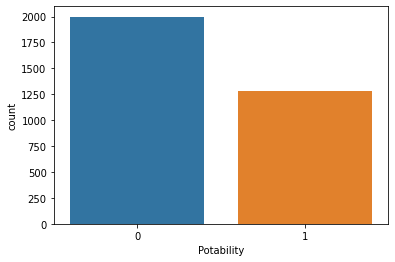

In [5]:
sns.countplot(df.Potability)

In [6]:
df.isna().sum(), df.shape[0]

(ph                 491
 Hardness             0
 Solids               0
 Chloramines          0
 Sulfate            781
 Conductivity         0
 Organic_carbon       0
 Trihalomethanes    162
 Turbidity            0
 Potability           0
 dtype: int64, 3276)

In [7]:
data = fast_knn(df.values, k=30)

In [8]:
df = pd.DataFrame(data=data, columns=df.columns)

In [9]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.427020,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0.0
1,3.716080,129.422921,18630.057858,6.635246,334.314632,592.885359,15.180013,56.329076,4.500656,0.0
2,8.099124,224.236259,19909.541732,9.275884,319.605289,418.606213,16.868637,66.420093,3.055934,0.0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0.0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0.0


In [10]:
df.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

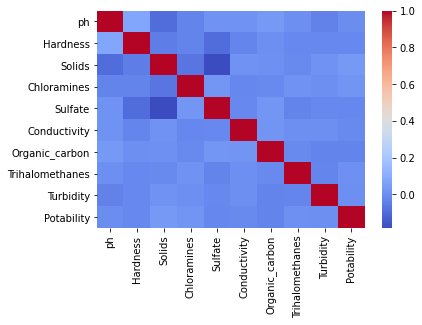

In [11]:
sns.heatmap(df.corr(), cmap='coolwarm')

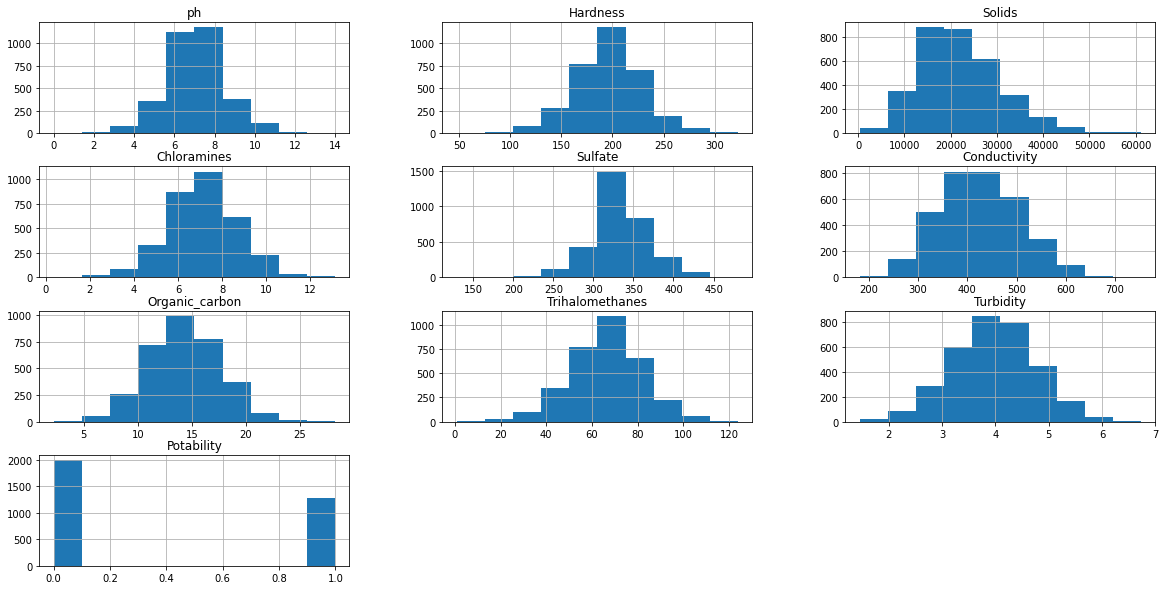

In [12]:
plt.rcParams['figure.figsize'] = [20,10]
df.hist()
plt.show()

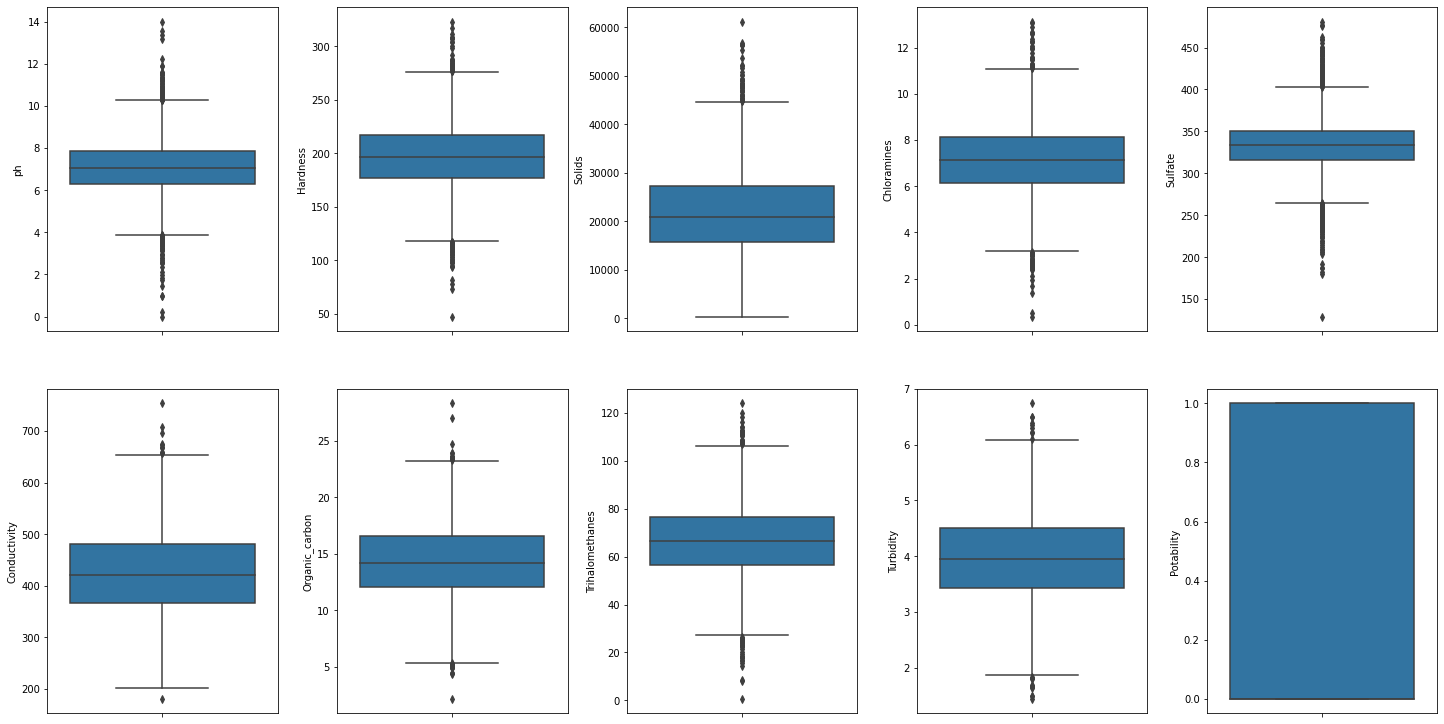

In [13]:
fig, ax = plt.subplots(ncols = 5, nrows = 2, figsize = (20, 10))
index = 0
ax = ax.flatten()

for col, value in df.items():
    sns.boxplot(y=col, data=df, ax=ax[index])
    index += 1
plt.tight_layout(pad = 0.5, w_pad=0.7, h_pad=5.0)

In [14]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.427020,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0.0
1,3.716080,129.422921,18630.057858,6.635246,334.314632,592.885359,15.180013,56.329076,4.500656,0.0
2,8.099124,224.236259,19909.541732,9.275884,319.605289,418.606213,16.868637,66.420093,3.055934,0.0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0.0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0.0


In [15]:
def ph_group(x):
  if x>=0 and x<=6:
    return 1
  elif x>6 and x<8:
    return 2
  else:
    return 3
df['ph_group'] = df.ph.apply(lambda x: ph_group(x))

In [16]:
for i in df.columns:
  print(f'{i}: {df.query("Potability == 0")[i].median()}, {df.query("Potability == 1")[i].median()}')

ph: 7.053691756859464, 7.04880029125804
Hardness: 197.12342321605394, 196.6329070886398
Solids: 20809.618279605398, 21199.38661404485
Chloramines: 7.090333864655992, 7.2151630099488235
Sulfate: 333.4423849175456, 333.5811414786993
Conductivity: 422.2293312022622, 420.71272912166967
Organic_carbon: 14.293507768607894, 14.162808700391992
Trihalomethanes: 66.47308689025851, 66.67643593002734
Turbidity: 3.9480762530520357, 3.9585762175676535
Potability: 0.0, 1.0
ph_group: 2.0, 2.0


In [17]:
zero  = df[df['Potability']==0]   #zero values in Potability column
one = df[df['Potability']==1]  # one values in Potability column
from sklearn.utils import resample
#minority class that  is 1, we need to upsample/increase that class so that there is no bias
#n_samples = 1998 means we want 1998 sample of class 1, since there are 1998 samples of class 0
df_minority_upsampled = resample(one, replace = True, n_samples = 1200) 
#concatenate
df = pd.concat([zero, df_minority_upsampled])

from sklearn.utils import shuffle
df = shuffle(df) # shuffling so that there is particular sequence

In [18]:
X = df.drop('Potability', axis=1)
y = df.Potability

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=17)

In [20]:
def metric(y_true, y_pred):
  print(f'roc_auc: {roc_auc_score(y_true, y_pred)}\nf1: {f1_score(y_true, y_pred)}\naccuracy: {accuracy_score(y_true, y_pred)}\nrecall: {recall_score(y_true, y_pred)}\nprecision: {precision_score(y_true, y_pred)}')

In [21]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [22]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)
metric(y_test, rf.predict(X_test))

roc_auc: 0.7721434820647419
f1: 0.7062499999999999
accuracy: 0.821969696969697
recall: 0.5931758530183727
precision: 0.8725868725868726


In [23]:
pd.DataFrame({'name': X_train.columns, 'feature': rf.feature_importances_}).sort_values('feature', ascending=False)

,name,feature
4,Sulfate,0.134250
0,ph,0.124447
1,Hardness,0.112051
2,Solids,0.109914
3,Chloramines,0.106935
7,Trihalomethanes,0.101681
5,Conductivity,0.100671
8,Turbidity,0.096980
6,Organic_carbon,0.096752
9,ph_group,0.016319


In [24]:
logit = LogisticRegression()
logit.fit(X_train_sc, y_train)
metric(y_test, logit.predict(X_test_sc))

roc_auc: 0.5122134733158356
f1: 0.05569620253164557
accuracy: 0.646780303030303
recall: 0.028871391076115485
precision: 0.7857142857142857


In [25]:
knn = KNeighborsClassifier()
knn.fit(X_train_sc, y_train)
metric(y_test, knn.predict(X_test_sc))

roc_auc: 0.6347389909594634
f1: 0.5157593123209169
accuracy: 0.6799242424242424
recall: 0.47244094488188976
precision: 0.5678233438485805


In [26]:
rf = RandomForestClassifier(class_weight='balanced')
params = {'n_estimators': range(50, 300, 20), 'max_depth': range(2, 21, 3), 'class_weight':['balanced', 'balanced_subsample']}
rf_gr = GridSearchCV(rf, params, scoring='roc_auc', n_jobs=-1, cv=5)
rf_gr.fit(X_train, y_train)
metric(y_test, rf_gr.predict(X_test)) 

roc_auc: 0.7680373286672499
f1: 0.7
accuracy: 0.8181818181818182
recall: 0.5879265091863517
precision: 0.8648648648648649


In [27]:
rf_gr.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=170,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [30]:
cross_val_score(rf_gr.best_estimator_, X, y, scoring='roc_auc', cv=5, n_jobs=-1).mean()

0.8411102208646616